In [1]:
#Keras 버전 확인
import keras
keras.__version__

Using TensorFlow backend.


'2.2.2'

# 오버피팅(Overfitting)과 언더피팅(Underfitting)

이 노트북(Notebook)에는 [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff)의 2장 1절에 포함된 샘플 코드가 있습니다. 원본 텍스트에 훨씬 더 많은 자료, 특히 추가 설명과 그림들이 포함되어 있습니다. 이 노트북에서는 예제 코드와 코드와 관련된 설명만 포함되어 있습니다.

---

영화 리뷰 감성 예측, 주제 분류, 그리고 주택 가격 회귀 등 이전 장에서 보았던 보든 예시들에서 우리 모델의 수행이 홀드아웃 검증 데이터에서 몇 번의 에폭(epoch)을 하고난 이후에 항상 최고점에 도달하며 곧 하향하기 시작하는데 이는 곧 우리가 설정한 모델이 훈련 데이터에 빠르게 오버핏(overfit)하기 때문입니다. 오버피팅은 모든 머신러닝에서 발생하는데요, 오버피팅에 적절하게 대처하는 법을 배우는 것은 머신러닝을 완벽하게 학습하는 것에 있어서 중요한 요소가 될 것입니다.

머신러닝에 있어서 근본적인 쟁점은 **최적화(Optimization)** 와 **일반화(Genralization)** 사이에서의 팽팽함을 유지하는 것입니다. '최적화'는 훈련 데이터에서 가능한 최선의 수행 결과를 얻기 위해 모델을 조정하는 과정을 나타내며("기계학습"의 "학습"이 이 의미를 뜻합니다), 반면에 '일반화'는 훈련된 모델이 이전에 훈련되지 않은 새로운 데이터를 만났을 때 얼마나 잘 수행 결과를 만들어 낼 수 있는지를 나타냅니다. 이 과정의 목표는 물론 좋은(good) 일반화 결과를 얻는 것이지만, 우리가 값을 조정할 수 있는 것은 오직 훈련 데이터를 기반으로한 모델 뿐이지, 좋은 '일반화' 값을 얻기 위해 이전에 훈련되지 않은 새로운 데이터(=테스트 데이터)를 조절해서는 안된다는 점입니다.

데이터 훈련의 시작에서 여러분이 훈련 데이터에서의 손실을 낮출수록 테스트 데이터에서의 손실을 낮출 수 있기에 최적화와 일반화는 상호 연관성을 갖습니다. 이 과정이 발생하고 있는 중이라면 여러분의 모델은 언더핏(underfit) 상태에 있는 것이라 말할 수 있으며 망(network)이 훈련 데이터에서 모든 연관있는 패턴들을 모델화 시키지 못했기 때문에 이 프로세스가 형성된 것이라 할 수 있습니다. 하지만 특정 수 이상의 많은 훈련 데이터의 반복은 일반화 과정이 향상되는 것을 정지시키고 검증 행렬판이 하락하기 시작합니다. 즉, 훈련된 모델이 오버핏 되기 시작하며, 훈련 데이터에 대해서는 세부적인 패턴을 배울 수 있지만 새로운 데이터에 대해서는 잘못되거나 연관성 없는 패턴을 학습할 것입니다. 

모델이 훈련 데이터에서 발견된 불규칙한 패턴이나 잘못된 학습을 하는 것을 방지하기 위해 최선의 선택은 당연히 *더 많은 훈련 데이터를 확보하는 것* 일 겁니다. 더 많은 데이터에 의해 훈련된 모델은 자연스럽게 더 일반화가 될 것입니다. 더 많은 데이터로 모델을 훈련시키는 것이 불가능 할 땐, 차선의 해결책으로 모델이 저장할 수 있는 정보의 양을 조절하거나, 저장할 수 있는 정보에 제약을 가하는 것일 겁니다. 만약 망이 적은 양의 패턴만을 수용할 수 있는 상황이라면, 최적화가 되어 과정은 가장 두드러진 패턴에 집중하도록 초점을 맞출 것이며 더 잘 일반화 시킬 수 있는 기회를 갖는 것이라 할 수 있겠습니다.

오버피팅과 분투하는 이 과정을 우리는 **정규화(Regularization)** 라고 합니다. 가장 일반적인 정규화 기술을 리뷰해보고, 이전 장에서 다루었던 영화 분류 모델을 향상시키기 위한 연습으로 정규화를 적용해보도록 합시다.

참고: 우리는 이 노트북에서 IMDB(Internet Moive Database) 테스트를 우리의 검증 세트로 사용할 것입니다. IMDB는 이 텍스트의 맥락과 관계 없습니다.

이번에는 [Deep Learning with Python]의 3장 5절에 있는 코드를 사용하여 데이터를 준비해보도록 합시다.

In [2]:
from keras.datasets import imdb
import numpy as np

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

# 오버피팅 해소하기

## 망(Network) 규모 감소시키기


오버피팅을 막는 가장 손쉬운 방법은 모델의 규모를 줄이는 것인데, 이는 모델의 학습가능한 매개변수의 수를 감소시키는 것을 뜻합니다(학습 가능한 매개변수의 수는 레이어당 *유닛(unit,해석이 불분명하네요)* 의 수와 레이어들의 갯수로 결정됩니다). 모델의 학습가능한 매개변수의 수는 딥러닝에서 종종 모델의 "수용량"을 나타내기도 합니다. 직관적으로 매개변수가 더 많은 모델은 "기억 수용량"이 더 많을 것이며 그러므로 훈련 샘플과 적용해볼 목표 사이에서 더욱 사전과 같이 완벽한 *매핑(mapping, 매핑? 지도화?)* 를 일반화의 힘없이 할 수 있을 것입니다. 예를 들어, 여기 MNIST(Modified Institute of Standards and Technology) 훈련 셋의 모든 숫자 분류를 쉽게 학습할 수 있도록 만들어진 50만개의 이원 매개변수로 이뤄진 모델이 있습니다. 우리는 각각의 5만개의 숫자마다 10개의 이원 매개변수가 필요할 뿐입니다. 이러한 모델에서는 새로운 숫자 샘플을 분류하는 것이 큰 의미를 갖지 않습니다. 항상 명심하셔야하실 점은 딥러닝 모델이 훈련 데이터에 적합한 것인지 의도하는 것이지만, 진짜 문제는 일반화이지, 적합의 여부를 따지는 것이 아닙니다.

위의 내용과는 반대로, 망이 제한적인 기억 용량을 가지고 있다면, 매개변수가 많을 때처럼 쉽게 매핑을 학습할 수 없을 것이기에 손실을 최소화하기 위해서는 목표에 관해 예측할 수 있는 능력을 가진 학습된 압축적 표현들-특히 우리가 관심갖는 표현의 종류들을 세부적으로-을 재분류하는 것일 것입니다. 이와 동시에 분명히 해야할 점은 모델들이 언더피팅 되지 않도록 충분한 매개 변수들을 모델들이 가져 우리가 사용해야한다는 점이며, 우리가 학습시킬 모델이 기억 용량이 부족해 모자르는 일이 있어서는 안된다는 것입니다. "수용량이 넘치는가"와 "수용량이 부족한가"의 사이에서의 적절한 타협점이 필요한 부분입니다.

안타깝게도 적정한 수의 레이어나 각 레이어 별로 적정한 레이어가 있는가에 대해 결정할 수 있는 기적같은 공식은 없습니다. 우리가 해야할 것은 여러분의 데이터에 맞는 모델의 규모를 찾기 위해 여러가지 다른 아키텍쳐들(물론 테스트 셋이 아닌 여러분의 검증셋)의 배열을 평가하는 것입니다. 적정한 모델 규모를 찾기위해 찾아야할 일반적인 작업 속도는 상대적으로 적은 레이어와 매개변수로 시작하며 검증 손실에 관해 줄어드는 반환값이 확인될 때까지 레이어들의 규모를 증가시키거나 새로운 레이어를 추가시키는 일일 겁니다.

이제 영화 리뷰를 분류하는 망에 위에서 설명한 것을 적용해봅시다. 우리의 원본 망은 밑의 소스코드와 같습니다.

In [4]:
from keras import models
from keras import layers

original_model = models.Sequential()
original_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
original_model.add(layers.Dense(16, activation='relu'))
original_model.add(layers.Dense(1, activation='sigmoid'))

original_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

이제 이것을 더 작은 망으로 대체해봅시다.

In [5]:
smaller_model = models.Sequential()
smaller_model.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
smaller_model.add(layers.Dense(4, activation='relu'))
smaller_model.add(layers.Dense(1, activation='sigmoid'))

smaller_model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['acc'])


여기 더 작은 망과 원본 방의 검증 값 손실에 관한 비교가 있습니다. 
점들은 작은 망의 검증 값 손실을 의미하며 교차되는 것들은 원본 망의 값을 의미합니다.(기억하셔야 할 것은 더 낮은 검증 값의 손실은 더 나은 모델을 의미합니다.)

In [7]:
original_hist = original_model.fit(x_train, y_train,
                                   epochs=20,
                                   batch_size=512,
                                   validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 17s 681us/step - loss: 0.4440 - acc: 0.8244 - val_loss: 0.3288 - val_acc: 0.8845
Epoch 2/20
25000/25000 [==============================] - 10s 395us/step - loss: 0.2575 - acc: 0.9080 - val_loss: 0.2859 - val_acc: 0.8885
Epoch 3/20
25000/25000 [==============================] - 9s 341us/step - loss: 0.1992 - acc: 0.9289 - val_loss: 0.2821 - val_acc: 0.8886
Epoch 4/20
25000/25000 [==============================] - 8s 310us/step - loss: 0.1663 - acc: 0.9414 - val_loss: 0.2942 - val_acc: 0.8844
Epoch 5/20
25000/25000 [==============================] - 7s 291us/step - loss: 0.1424 - acc: 0.9504 - val_loss: 0.3123 - val_acc: 0.8804
Epoch 6/20
25000/25000 [==============================] - 8s 301us/step - loss: 0.1244 - acc: 0.9565 - val_loss: 0.3521 - val_acc: 0.8715
Epoch 7/20
25000/25000 [==============================] - 7s 300us/step - loss: 0.1102 - acc: 0.9617 - val_loss: 0.3591 

In [8]:
smaller_model_hist = smaller_model.fit(x_train, y_train,
                                       epochs=20,
                                       batch_size=512,
                                       validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 9s 372us/step - loss: 0.5804 - acc: 0.7027 - val_loss: 0.5307 - val_acc: 0.7574
Epoch 2/20
25000/25000 [==============================] - 8s 332us/step - loss: 0.4843 - acc: 0.8456 - val_loss: 0.4875 - val_acc: 0.8288
Epoch 3/20
25000/25000 [==============================] - 7s 293us/step - loss: 0.4389 - acc: 0.8928 - val_loss: 0.4661 - val_acc: 0.8506
Epoch 4/20
25000/25000 [==============================] - 8s 320us/step - loss: 0.4077 - acc: 0.9154 - val_loss: 0.4537 - val_acc: 0.8631
Epoch 5/20
25000/25000 [==============================] - 8s 321us/step - loss: 0.3831 - acc: 0.9303 - val_loss: 0.4515 - val_acc: 0.8614 2
Epoch 6/20
25000/25000 [==============================] - 7s 297us/step - loss: 0.3620 - acc: 0.9407 - val_loss: 0.4440 - val_acc: 0.8707
Epoch 7/20
25000/25000 [==============================] - 9s 346us/step - loss: 0.3425 - acc: 0.9510 - val_loss: 0.4488 

In [9]:
epochs = range(1, 21)
original_val_loss = original_hist.history['val_loss']
smaller_model_val_loss = smaller_model_hist.history['val_loss']

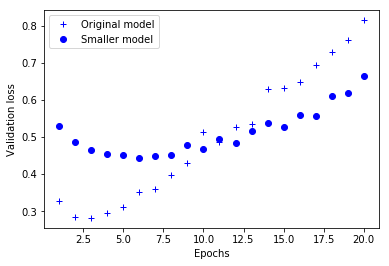

In [12]:
import matplotlib.pyplot as plt

# b+ is for "blue cross"
plt.plot(epochs, original_val_loss, 'b+', label='Original model')
# "bo" is for "blue dot"
plt.plot(epochs, smaller_model_val_loss, 'bo', label='Smaller model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()